# Convolutional neural network for classifying images of characters using MNIST dataset


One very commmon, very important task in the world of processing information is interpreting visual representations of languages. This includes looking at street signs, hand-written documents, typed documents in various fonts, grafitti, etc. 

The MNIST data set only included the numeric digits 0-9. We can start with these and learn the letters later.

## Load necessary packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from scipy import misc
import os

In [2]:
tf.__version__

'1.7.0'

## Define network architecture

The network designed here will be very small, easy to train, and optimized for the MNIST dataset. This dataset has 10 classes of data representing the digits 0-9. 

The network consists of two convolutional layers for downsampling the images, a fully-connected layer for learning a large number of features from the downsampled image, and a softmax layer for classifying the features vector. 

For this network, the input layer will expect an array of grayscale images of the shape (n_images, x_pixels, y_pixels, 1), and the number of pixels in both directions will be 28.

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

num_channels = 1          # Number of color channels in the image
num_classes = 62          # Classify digits 0-9, chars A-Z and a-z
img_size = 28             # Make images 28 x 28 pixels

img_shape = (img_size, img_size)
img_size_flat = img_size**2

## Loading the MNIST data set using MNIST module

It is very easy to load the training and testing images and class labels from the MNIST module. Simply set the directory where the data is stored (if not found, it will be downloaded), and call the respective functions to retreive the data.

First, define a helper function or two...

In [4]:
def get_one_hots_from_cls(labels, num_classes):
    one_hot = np.zeros(shape=[len(labels), num_classes], dtype=np.int)
    for idx, label in enumerate(labels):
        one_hot[idx][label] = 1
    return one_hot

In [93]:
# Load
mnist.temporary_dir = lambda: 'data/MNIST'
# Training images
train_images = mnist.train_images()
n_train = train_images.shape[0]
train_images = train_images.reshape([n_train, img_size, img_size, 1])
# Training labels
train_labels_cls = mnist.train_labels()
train_labels = get_one_hots_from_cls(train_labels_cls)
# Test images
test_images = mnist.test_images()
n_test = test_images.shape[0]
test_images = test_images.reshape([-1, img_size, img_size, 1])
# Test labels
test_labels_cls = mnist.test_labels()
test_labels = get_one_hots_from_cls(test_labels_cls)

## Load the Chars74K dataset

To instread load the Chars74K dataset, we will define some helper functions for grabbing the images from file, creating corresponding label vectors, shuffling, and splitting the data.

In [5]:
def load_chars74k_package(path, label):
    images = []
    fnames = os.listdir(path)
    for f in fnames: 
        cur_png = misc.imread(os.path.join(path, f))
        cur_png = misc.imresize(cur_png, img_shape)
        # Invert image
        images.append(255 - cur_png)
    labels = [label for item in images]
    return np.array(images), np.array(labels)

def load_all_chars74k_numeric_fonts():
    images = []
    labels = []
    path = 'data/Chars74K/EnglishFont/Fnt/Sample'
    for i in range(1, 11):
        if i == 10:
            cur_path = path + '0' + str(i)
        else:
            cur_path = path + '00' + str(i)
        for f in os.listdir(cur_path):
            cur_png = misc.imread(os.path.join(cur_path, f))
            cur_png = misc.imresize(cur_png, img_shape)
            # Invert image
            images.append(255 - cur_png)
            labels.append(i - 1)
    return np.array(images), np.array(labels)

def load_all_chars74k(load_fonts=True):
    images = []
    labels = []
    if load_fonts:
        path = 'data/Chars74K/EnglishFont/Fnt/Sample'
    else:
        path = 'data/Chars74K/EnglishImg/Img/GoodImg/Bmp/Sample'
    for i in range(1, 63):
        if i > 9:
            cur_path = path + '0' + str(i)
        else:
            cur_path = path + '00' + str(i)
        for f in os.listdir(cur_path):
            cur_png = misc.imread(os.path.join(cur_path, f))
            cur_png = misc.imresize(cur_png, img_shape)
            # Invert image
            images.append(255 - cur_png)
            labels.append(i - 1)
    return np.array(images), np.array(labels)

def shuffle_data(x, y, y_cls):
    sidx = np.random.permutation(len(x))
    x_out, y_out, y_out_cls = [], [], []
    for idx in sidx:
        x_out.append(x[idx])
        y_out.append(y[idx])
        y_out_cls.append(y_cls[idx])
    return np.array(x_out), np.array(y_out), np.array(y_out_cls)

def get_class_char(idx):
    if idx < 10:
        return str(idx)
    elif idx < 36:
        return chr(idx + 55)
    else:
        return chr(idx + 61)

In [6]:
# Load
train_images, train_labels_cls = load_all_chars74k()
train_labels = get_one_hots_from_cls(train_labels_cls, num_classes)
# Shuffle
train_images, train_labels, train_labels_cls = \
    shuffle_data(train_images, train_labels, train_labels_cls)
# Reshape
train_images = train_images.reshape([-1, img_size, img_size, 1])

# Split
test_split = 0.2
n_train = int(train_images.shape[0] * (1.0 - test_split))
n_test = train_images.shape[0] - n_train

test_images = train_images[:n_test]
test_labels = train_labels[:n_test]
test_labels_cls = train_labels_cls[:n_test]

train_images = train_images[n_test:]
train_labels = train_labels[n_test:]
train_labels_cls = train_labels_cls[n_test:]

/home/brady/tf-gpu-36/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/brady/tf-gpu-36/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


### Print size info

In [7]:
print("Size of:")
print(" - Training set:\t" + str(n_train))
print(" - Testing set:\t\t" + str(n_test))
print(" - Images shape: \t" + str(train_images.shape))
print(" - Labels shape: \t" + str(train_labels.shape))

Size of:
 - Training set:	50393
 - Testing set:		12599
 - Images shape: 	(50393, 28, 28, 1)
 - Labels shape: 	(50393, 62)


## Plot some images using helper function

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(get_class_char(cls_true[i]))
        else:
            xlabel = "True: {0}, Pred: {1}".format(get_class_char(cls_true[i]), 
                                                   get_class_char(cls_pred[i]))

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

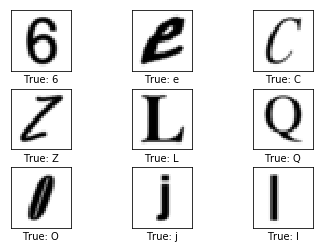

In [9]:
# Get the first images from the test-set.
index = np.random.randint(n_test)
images = test_images[index:index+9]

# Get the true classes for those images.
cls_true = test_labels_cls[index:index+9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Define helper functions for the network

Neural networks are complex things with many degrees of freedom. There are a few functions that we must perform repeatedly that take many inputs. With helper functions, we can hard-code some things and reduce the number of inputs to make the problem easier to manage.

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [12]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [13]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [14]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

## Create TensorFlow input and output

We need to now create the Tensorflow variables and graph. This included placeholders for the inputs (images array and one-hot labels array), as well as a computation we want performed (the network). 

 - The input image placeholder is called x_image
 - The input labels placeholder is called y_true
 - The final output computation is called y_pred
    * y_pred is the final output activations from the softmax layer of the network.

In [15]:
#x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
#x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
x_image = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1], name='x_image')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [16]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv2)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, axis=1)

## Tell Tensorflow how to create the output from input

When we give tensorflow a set of images vectors, a set of label vectors, and a computation graph, we have given it everything it needs to find a mapping from image to label; however, there are many ways to find this mapping. 

Of course you have heard of gradient descent. We define a loss function which has a value of zero when the prediction is equal to the true label. We will use AdamOptimizer as our gradient descent algorithm. Now we have told Tensorflow the inputs, the outputs, how to make predictions, and how to get good at making predictions.

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Create a Tensorflow session

Tensorflow is not doing anything yet. We have created some Tensorflow structures, but no computuation has been performed. We were just at the drawing board having a discussion.

Now, let's fire up the Tensorflow computation engine, initialize all the variables we had "discussed" before, and perform the planned computations.

In [18]:
session = tf.Session()

In [19]:
session.run(tf.global_variables_initializer())

### More helper functions for optimization, evaluation, and printing

Now that we have a "session" defined and running, we will write a couple more helper functions that use a reference to that session. These helper functions will actually call on tensorflow to compute predictions given input (and sometimes, perform optimization)

In [20]:
def get_random_batch(x, y, batch_size):
    sidx = np.random.permutation(len(x))
    x_out, y_out = [], []
    for i in range(batch_size):
        x_out.append(x[sidx[i]])
        y_out.append(y[sidx[i]])
    return np.array(x_out), np.array(y_out)

In [21]:
total_iterations = 0

In [22]:
train_batch_size = 64

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = \
            get_random_batch(train_images, train_labels, train_batch_size)
        feed_dict_train = {x_image: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
            
            
    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [23]:
def plot_example_errors(cls_pred, cls_true, images):
    incorrect = (cls_pred != cls_true)
    images = images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]
    plot_images(images=images[0:9], 
                cls_true=cls_true[0:9], 
                cls_pred=cls_pred[0:9])

In [24]:
def plot_confusion_matrix(cls_pred, cls_true):
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [25]:
def print_accuracy(pred_labels, true_labels):
    n_images = pred_labels.shape[0]
    correct = (pred_labels == true_labels)
    correct_sum = correct.sum()
    acc = float(correct_sum) / n_images
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, n_images))

In [26]:
def predict(images, labels):
    feed_dict = {x_image: images,
                 y_true: labels}
    return session.run(y_pred_cls, feed_dict=feed_dict)

In [27]:
def predict_in_batches(images, labels, batch_size = 64):
    n_images = images.shape[0]
    cls_pred = np.zeros(shape=n_images, dtype=np.int)
    i = 0
    while i < n_test:
        j = min(i + batch_size, n_images)
        cls_pred[i:j] = predict(images[i:j], labels[i:j])
        i = j
    return cls_pred

In [28]:
def evaluate_model():
    print_accuracy(test_predictions, test_labels_cls)
    plot_example_errors(test_predictions, test_labels_cls, test_images)
    plot_confusion_matrix(test_predictions, test_labels_cls)

## Update the weights using the optimizer

The job of the optimizer is to optimize the value of the weights in each layer so that the computation graph results in the correct label for the given input.

Run the optimizer for some number of iteration. The model learns very quickly (under 100 iterations) how to correctly classify images at least 80% of the time. It takes a bit longer (over 1,000 iterations) to drive that accuracy up to 98%. 

Optimizing the hyper-parameters (changing model architecture, optimiziation algorithm, using regularization, changing data input, etc.) can help get the accuracy above 99%.

In [29]:
test_predictions = predict_in_batches(test_images, test_labels)
print_accuracy(test_predictions, test_labels_cls)

Accuracy on Test-Set: 1.8% (224 / 12599)


In [33]:
optimize(num_iterations=10000)

Optimization Iteration:   1101, Training Accuracy:  70.3%
Optimization Iteration:   1201, Training Accuracy:  81.2%
Optimization Iteration:   1301, Training Accuracy:  76.6%
Optimization Iteration:   1401, Training Accuracy:  87.5%
Optimization Iteration:   1501, Training Accuracy:  79.7%
Optimization Iteration:   1601, Training Accuracy:  85.9%
Optimization Iteration:   1701, Training Accuracy:  75.0%
Optimization Iteration:   1801, Training Accuracy:  81.2%
Optimization Iteration:   1901, Training Accuracy:  85.9%
Optimization Iteration:   2001, Training Accuracy:  89.1%
Optimization Iteration:   2101, Training Accuracy:  89.1%
Optimization Iteration:   2201, Training Accuracy:  92.2%
Optimization Iteration:   2301, Training Accuracy:  71.9%
Optimization Iteration:   2401, Training Accuracy:  84.4%
Optimization Iteration:   2501, Training Accuracy:  87.5%
Optimization Iteration:   2601, Training Accuracy:  82.8%
Optimization Iteration:   2701, Training Accuracy:  87.5%
Optimization I

Accuracy on Test-Set: 88.5% (11144 / 12599)


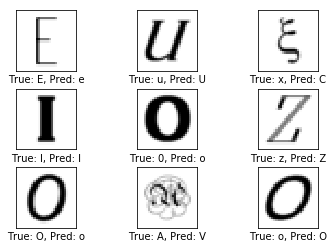

[[180   0   0 ...   0   0   0]
 [  0 204   0 ...   0   0   1]
 [  0   1 200 ...   0   0   0]
 ...
 [  0   0   0 ... 146   0   1]
 [  0   0   0 ...   0 187   0]
 [  0   0   0 ...   1   0 187]]


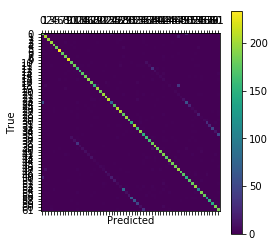

In [34]:
test_predictions = predict_in_batches(test_images, test_labels)
evaluate_model()

## Take a look under the hood

What does the neural network see? What does it pay attention to? Is it looking for lines, curves, loops? Is it only performing so well because of some bias in the data set? 

The model takes in 784 numbers (28 x 28 x 1) and from those numbers chooses 128 numbers that contain all the important information for classifying the input.

Convolutional layers slide from side to side, top to bottom over input images and create a smaller output image. By looking at what comes out of the first layer and into the second, perhaps we will gain insight into the strengths and weaknesses of the model and understand its performance.

In [118]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                     interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [119]:
def plot_conv_layer(layer, image):
    feed_dict = {x_image: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [109]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape), interpolation='nearest', cmap='binary')
    plt.show()

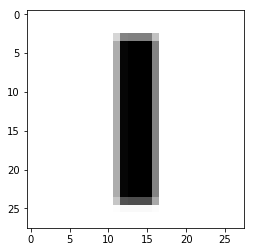

In [120]:
index = 216
image = test_images[index]
label = test_labels_cls[index]
plot_image(image)

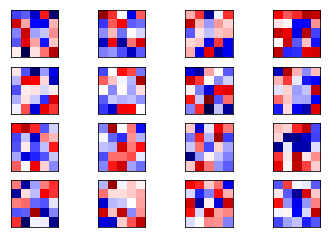

In [121]:
plot_conv_weights(weights=weights_conv1)

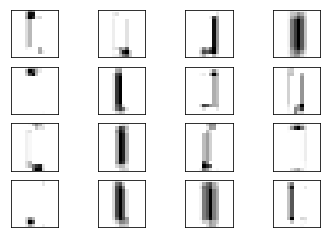

In [122]:
plot_conv_layer(layer=layer_conv1, image=image)

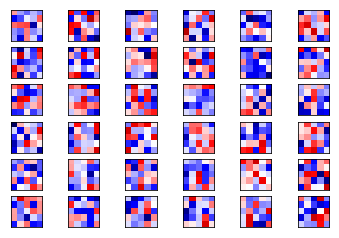

In [123]:
plot_conv_weights(weights=weights_conv2, input_channel=2)

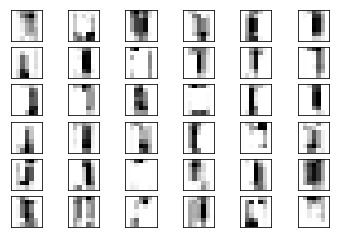

In [124]:
plot_conv_layer(layer=layer_conv2, image=image)

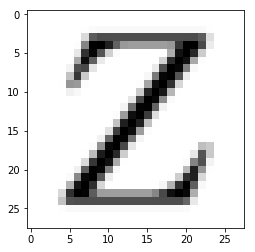

Index: 		14509
Prediction: 	35
Label: 		61


In [115]:
index = np.random.randint(n_train)
image = train_images[index]
label = train_labels_cls[index]
plot_image(image)

print("Index: \t\t" + str(index))
predict(image, label)

In [35]:
if False:
    saver = tf.train.Saver()
    saver.save(session, 'models/chars74k.ckpt')

In [32]:
if False:
    saver = tf.train.Saver()
    saver.restore(session, 'models/mnist.ckpt')

INFO:tensorflow:Restoring parameters from models/mnist.ckpt


In [40]:
session.close()